In [1]:
%env NUMBA_NUM_THREADS=4
%env OMP_NUM_THREADS=4

env: NUMBA_NUM_THREADS=4
env: OMP_NUM_THREADS=4


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import sys,os
sys.path.insert(0,'../')

In [30]:
from ml_tools.descriptors import RawSoapQUIP
from ml_tools.models import SoRTrainer,MLCalculator
from ml_tools.utils import get_mae,get_rmse,get_sup,get_spearman,get_score,load_pck,dump_obj,load_obj
from ml_tools.split import KFold,LCSplit,ShuffleSplit
from ml_tools.compressor import FPSFilter,CURFilter

In [23]:
import numpy as np
from ase.io import read,write
from ase.visualize import view
import ase

# Warning 

The original settings (N=2000) will need ~7Gb of RAM to run properly

In [6]:
# Total number of structure to load
N = 2000
# Number of structure to train the model with
f = int(0.8*N)

# load the structures
frames = read('data/molecule_conformers_dftb.xyz',':{}'.format(N))
global_species = []
for frame in frames:
    global_species.extend(frame.get_atomic_numbers())
    frame.set_cell(np.eye(3)*30)
global_species = np.unique(global_species)

# split the structures in 2 sets
ids = range(N)
np.random.seed(10)
np.random.shuffle(ids)

frames_train = [frames[ii] for ii in ids[:f]]
frames_test = [frames[ii] for ii in ids[f:]]

# set up the soap parameters
soap_params = dict(rc=3.5, nmax=6, lmax=6, awidth=0.4,
                       global_species=global_species,nocenters=[],
                       centerweight=1.,cutoff_transition_width=0.5, cutoff_rate=1,
                     cutoff_dexp=0, cutoff_scale=1.,grad=True)

representation = RawSoapQUIP(**soap_params)

# Isolated atom contributions
self_en = {
    1: -6.492647589968434,
    6: -38.054950840332474,
    8: -83.97955098636527,
}

In [18]:
# utility functions
def extract_ref(frames,info_key,array_key):
    y,f = [], []
    for frame in frames:
        y.append(frame.info[info_key])
        if array_key is None:
            pass
        elif array_key == 'zeros':
            f.append(np.zeros(frame.get_positions().shape))
        else:
            f.append(frame.get_array(array_key))
    y= np.array(y)
    try:
        f = np.concatenate(f)
    except:
        pass
    return y,f
def format_score(scores):
    return ' '.join(map(lambda x:'{}={:.2e}'.format(*x), scores.items()))


# Build an interatomic potential

In [1]:
# extract the reference data
y_train, f_train = extract_ref(frames_train,'dftb_energy_eV','dftb_forces_eV_per_Ang')
y_test, f_test = extract_ref(frames_test,'dftb_energy_eV','dftb_forces_eV_per_Ang')

NameError: name 'extract_ref' is not defined

In [9]:
# Compute the soap representation and its gradients
X = representation.transform(frames_train)
X_test = representation.transform(frames_test)

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdSYXdTb2FwJywgbWF4PTE4MDAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGg9dSfigKY=


SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdSYXdTb2FwJywgbWF4PTEyMDAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2lkdGg9dSfigKY=


In [11]:
# Select pseudo input with CUR decomposition
X_pseudo = {}
n_pseudo = {1:400,6:300,8:200}

compressor = CURFilter(n_pseudo,act_on='sample per specie')
compressor.fit(X)

X_pseudo = compressor.transform(X)

8
Err=2.399e-07
1
Err=6.388e-05
6
Err=3.450e-05


In [12]:
# Setup the model parameters and precompute the kernel
trainer = SoRTrainer(model_name='krr', kernel_name='gap',
                     feature_transformations=representation,zeta = 2,self_energies=self_en)
trainer.precompute(y_train, X, X_pseudo, f_train=f_train)

In [19]:
# train the model and predict on the test set
model = trainer.fit(lambdas=[7e-3,1e-2],jitter=6e-7)

y_pred = model.predict(X_test,eval_gradient=False)
f_pred = -model.predict(X_test,eval_gradient=True)
scores = get_score(y_pred,y_test)
f_scores = get_score(f_pred.flatten(),f_test.flatten())
print format_score(scores)
print format_score(f_scores)

RMSE=8.81e-03 MAE=5.78e-03 R2=1.00e+00 CORR=1.00e+00 SUP=4.86e-02
RMSE=5.45e-02 MAE=3.57e-02 R2=9.98e-01 CORR=9.98e-01 SUP=1.12e+00


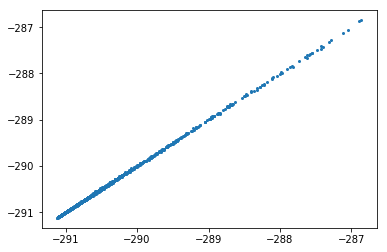

In [20]:
plt.plot(y_pred,y_test,'o',ms=2)

# Test it on dimer configurations

In [24]:
#creating atoms pairs, H is 1, C is 6 and O is 8, the first atom is the origin one
pairs = [[1,1],[6,6],[8,8],[6,1],[8,1],[6,8]]
ndists = 40 #number of distances to look at
dists = np.linspace(0.1,4.9,ndists) #distance list, can be changed 
print 'Number of configurations: ', len(pairs)*len(dists)

Number of configurations:  240


In [25]:
frames = []
for p in pairs:
    for d in dists:
        #using ase we can create the cell and place the atoms
        atoms = ase.Atoms(numbers=p,pbc=False,cell=np.eye(3)*100,positions=[[0,0,0],[d,0,0]])
        frames.append(atoms)
e_pairs = model.predict(frames)
e_pairs -= e_pairs.mean() 

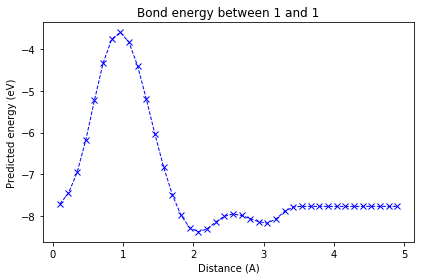

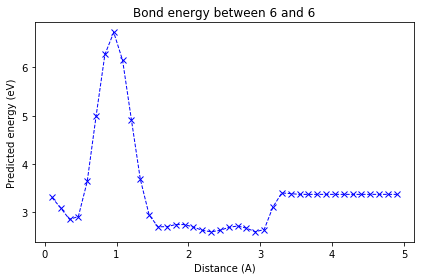

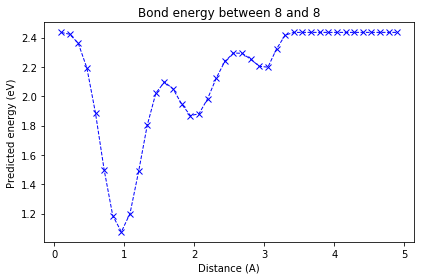

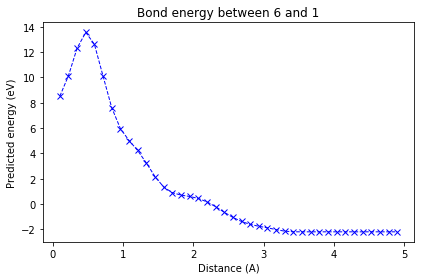

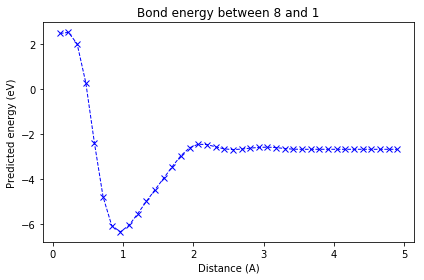

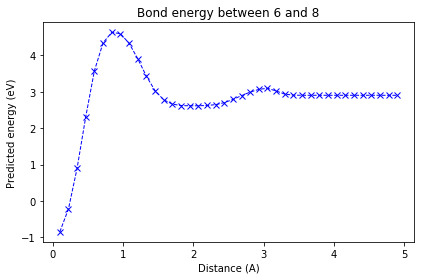

In [26]:
for pair_to_plot in pairs:
    i = pairs.index(pair_to_plot)

    fig, ax = plt.subplots()
    ax.plot(dists,e_pairs[i*ndists:(i+1)*ndists],'--xb',linewidth=1)
    # ax.plot(dists,f_pairs[i*ndists:(i+1)*ndists],'--xr',linewidth=1)
    ax.set_xlabel('Distance (A)')
    ax.set_ylabel('Predicted energy (eV)')
    ax.set_title('Bond energy between {} and {}'.format(*pair_to_plot))
    plt.tight_layout()
    plt.show()

# Use it to run a MD simulation

In [31]:
from ase.md import MDLogger
from ase.md.langevin import Langevin
from ase import units
from ase.io.trajectory import Trajectory
from ase.md.velocitydistribution import (MaxwellBoltzmannDistribution,
                                         Stationary, ZeroRotation)

In [35]:
log_fn = 'md.log'
filename = 'md.traj'

T = 200

atoms = read('./data/molecule_conformers_dftb.xyz',0)

atoms.set_cell(np.eye(3)*30)
atoms.set_pbc(False)

MaxwellBoltzmannDistribution(atoms, T* units.kB)
Stationary(atoms)
ZeroRotation(atoms) 

calc = MLCalculator(model)

atoms.set_calculator(calc)

traj = Trajectory(filename, mode='w', atoms=atoms, master=None)

dyn = Langevin(atoms, 0.5 * units.fs, units.kB * T, 0.002, trajectory=traj)

dyn.attach(MDLogger(dyn, atoms, log_fn, header=True, stress=False,
           peratom=False, mode="w"), interval=50)

dyn.attach(traj.write, interval=10)

dyn.run(1000)

In [36]:
view(read(filename,':'))